# 🧬 Gene Alignment + Joint PCA on Pseudo-Bulk Datasets

In this notebook, we align genes across the pancancer and breast pseudo-bulk datasets, filter to the common genes, apply joint PCA, and prepare the merged data for modeling.


In [19]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


## 📥 Load Datasets

We begin by loading both pseudo-bulk expression matrices and checking their gene coverage.


In [20]:
# Load both datasets
pan_df = pd.read_csv("pan_cancer/data/pancancer_pseudobulk_expression.csv", index_col=0)
breast_df = pd.read_csv("breast_cancer_pseudobulk_mapped.csv", index_col=0)

print("✅ Loaded pancancer:", pan_df.shape)
print("✅ Loaded breast:", breast_df.shape)
print("Gene overlap:", len(set(pan_df.columns) & set(breast_df.columns)))



✅ Loaded pancancer: (140, 30314)
✅ Loaded breast: (28, 47022)
Gene overlap: 24726


## 🧬 Align Gene Sets

We'll keep only the genes shared between both datasets.


In [21]:
# Get common genes
common_genes = list(set(pan_df.columns) & set(breast_df.columns))
print(f"✅ Number of common genes: {len(common_genes)}")

# Filter both datasets
pan_df_aligned = pan_df[common_genes].copy()
breast_df_aligned = breast_df[common_genes].copy()


✅ Number of common genes: 24726


## 📊 Combine Aligned Data and Apply Joint PCA


In [22]:
# Add source labels
pan_df_aligned["SANGER_MODEL_ID"] = pan_df.index
pan_df_aligned["pseudo_source"] = "pancancer"

breast_df_aligned["SANGER_MODEL_ID"] = breast_df.index
breast_df_aligned["pseudo_source"] = "breast"

# Combine
combined_df = pd.concat([pan_df_aligned, breast_df_aligned], axis=0)
combined_df.set_index("SANGER_MODEL_ID", inplace=True)

# Separate labels and expression
source_labels = combined_df.pop("pseudo_source")
expr_matrix = combined_df


## 🧪 Apply PCA on Combined Expression Matrix


In [23]:
NUM_PCS = 30

pca = PCA(n_components=NUM_PCS, random_state=42)
pcs = pca.fit_transform(expr_matrix)

pcs_df = pd.DataFrame(pcs, columns=[f"PSEUDO_PC{i+1}" for i in range(NUM_PCS)])
pcs_df["SANGER_MODEL_ID"] = expr_matrix.index
pcs_df["pseudo_source"] = source_labels.values

print("✅ PCA shape:", pcs_df.shape)


✅ PCA shape: (168, 32)


## 📈 Cumulative Explained Variance


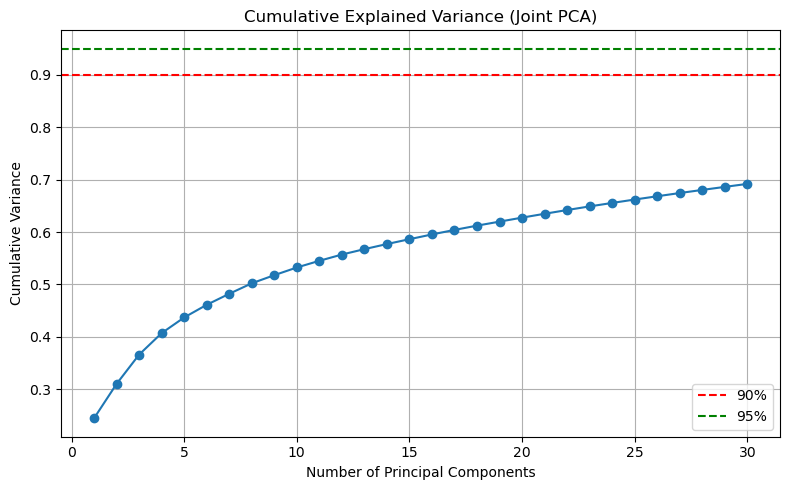

In [24]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_PCS + 1), cumulative_var, marker="o")
plt.axhline(0.9, linestyle="--", color="red", label="90%")
plt.axhline(0.95, linestyle="--", color="green", label="95%")
plt.title("Cumulative Explained Variance (Joint PCA)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 💾 Save PCA Components for Merging/Modeling


In [25]:
pcs_df.to_parquet("pseudobulk_joint_pca.parquet", index=False)
print("📁 Saved to pseudobulk_joint_pca.parquet")


📁 Saved to pseudobulk_joint_pca.parquet


In [31]:
import polars as pl

# 📥 Load GDSC drug response data
gdsc_bulk = pl.read_parquet("../bulk_state_of_the_art/data/bulk/gdsc_final_cleaned.parquet").select([
    pl.col("SANGER_MODEL_ID").cast(pl.Utf8),
    pl.col("DRUG_ID").cast(pl.Int32),
    pl.col("LN_IC50").cast(pl.Float32)
])

# 📥 Load your pseudo-bulk PCA features
pseudo_pca = pl.read_parquet("pseudobulk_joint_pca.parquet").with_columns(
    pl.col("SANGER_MODEL_ID").cast(pl.Utf8)
)

# 🔗 Merge GDSC with PCA-transformed pseudo-bulk profiles
merged = gdsc_bulk.join(pseudo_pca, on="SANGER_MODEL_ID", how="left")

# 🚫 Drop rows where any of the PCA columns are null
merged_filtered = merged.drop_nulls()

print("✅ Filtered merged dataset to only rows with PCA features.")
print(f"Final shape after filtering: {merged_filtered.shape}")
print(merged_filtered.head())

# 💾 Save
merged_filtered.write_parquet("gdsc_pseudobulk_pca.parquet")
print("📁 Saved to 'bulk_with_pseudobulk_pca.parquet'")


✅ Filtered merged dataset to only rows with PCA features.
Final shape after filtering: (102127, 34)
shape: (5, 34)
┌────────────┬─────────┬──────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ SANGER_MOD ┆ DRUG_ID ┆ LN_IC50  ┆ PSEUDO_PC1 ┆ … ┆ PSEUDO_PC ┆ PSEUDO_PC ┆ PSEUDO_PC ┆ pseudo_so │
│ EL_ID      ┆ ---     ┆ ---      ┆ ---        ┆   ┆ 28        ┆ 29        ┆ 30        ┆ urce      │
│ ---        ┆ i32     ┆ f32      ┆ f64        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆         ┆          ┆            ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str       │
╞════════════╪═════════╪══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ SIDM00272  ┆ 1449    ┆ 5.609114 ┆ -26.468677 ┆ … ┆ -1.407419 ┆ 1.636157  ┆ 0.585393  ┆ breast    │
│ SIDM00494  ┆ 1170    ┆ 4.66232  ┆ 3.430707   ┆ … ┆ -1.173673 ┆ 1.858871  ┆ 1.153348  ┆ pancancer │
│ SIDM00890  ┆ 1531    ┆ 5.60544  ┆ 6.238808   ┆ … ┆ 2.908849  ┆ 1.834218  ┆ 